In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import ipynbname
script_dir = os.getcwd()
filename = ipynbname.name()

from sde.SDE_ARFF_lib import (
    SDEARFFTrain,
    NNHyperparameters,
    MeanMinLoss
)

from sde.experiment_reports import (
    sample_data,
    plot_results_functions,
    histogram_data,
    plot_histogram
)

%load_ext autoreload
%autoreload 2

2025-05-25 18:45:09.542962: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-25 18:45:09.547362: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-25 18:45:09.547375: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# notebook parameters
random_seed = 1
step_size = .25
n_pts = 20000

n_dimensions = 3

In [6]:
# EXAMPLE 2
def f_1(x):
    A = 0
    B = np.array([[-1], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def f_2(x):
    A = 0
    B = np.array([[0], [-1], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def f_3(x):
    A = 0
    B = np.array([[0], [0], [-1]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    f = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return f


def true_drift(x):
    drift = np.transpose(np.array([f_1(x), f_2(x), f_3(x)]))
    return drift


def sigma_11(x):
    A = 0.02045836
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_12(x):
    A = -0.03502162
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_13(x):
    A = -0.02678421
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_22(x):
    A = 0.06355898
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_23(x):
    A = 0.02981971
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def sigma_33(x):
    A = 0.12453806
    B = np.array([[0], [0], [0]])
    C = np.array([[0], [0], [0]])
    D = np.array([[0], [0], [0]])
    sigma = np.squeeze(A + np.dot(x, B) + np.dot(np.square(x), C) + np.dot(np.power(x, 3), D))
    return sigma


def true_diffusion(x):
    diffusion = np.abs(np.transpose(np.array([[sigma_11(x), sigma_12(x), sigma_13(x)], [sigma_12(x), sigma_22(x), sigma_23(x)], [sigma_13(x), sigma_23(x), sigma_33(x)]])))
    return diffusion


def true_drift_diffusion(x, param=None):
    return true_drift(x), true_diffusion(x)


print(true_diffusion((0,0,0)))

rng = np.random.default_rng(random_seed)

xlim = np.array([[-1, 1], [-1, 1], [-1, 1]])

x_data, y_data = sample_data(true_drift_diffusion,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=xlim[:,0], high=xlim[:,1], n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusion,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=xlim[:,0], high=xlim[:,1],
                                       n_pts=n_pts//10, rng=rng)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

print('data shape', x_data.shape)

[[0.02045836 0.03502162 0.02678421]
 [0.03502162 0.06355898 0.02981971]
 [0.02678421 0.02981971 0.12453806]]
data shape (20000, 3)


In [7]:
# network parameters
validation_split = .1
ARFF_validation_split = .1

drift_param = NNHyperparameters(K=2**7, 
                                M_min=10,
                                M_max=500,
                                lambda_reg=2e-6,
                                gamma=1,
                                delta=0.1,
                                name='drift')
diff_param = NNHyperparameters(K=drift_param.K,
                               M_min=drift_param.M_min,
                               M_max=drift_param.M_max,
                               gamma=drift_param.gamma,
                               delta=drift_param.delta,
                               name='diff')



In [8]:
MML = MeanMinLoss()
mean_loss, SD, SD_val = MML.get_MML(true_diffusion, n_dimensions, n_pts, validation_split, xlim, step_size)
print('Theoretical mean min loss:', mean_loss)
print('Loss standard deviation:', SD)
print('Validation loss standard deviation:', SD_val)

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, f"MML_{filename}.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_loss}\n")

Theoretical mean min loss: -11.341458440416373
Loss standard deviation: 0.009128709291752768
Validation loss standard deviation: 0.027386127875258306


drift epoch: 18


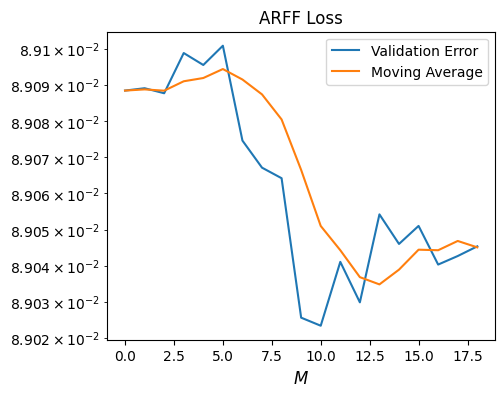

diff epoch: 10


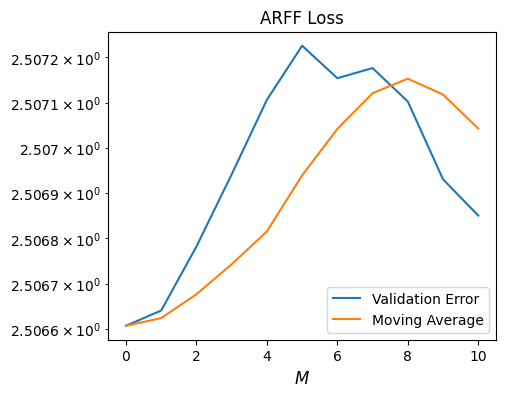

2025-05-25 18:46:27.990041: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-25 18:46:27.990156: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-25 18:46:27.990220: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/x86_64-linux-gnu:/usr/local/cuda-12.6/lib64::/usr/lib/x86_64-linux-gnu
2025-05-25 18:46:27.

Observed loss: -9.264905777527023
Observed validation loss: -9.24543926830228
True function validation loss: -11.299250215968659
Training time: 4.9738929271698


In [10]:
No_of_tests = 1
training_time = np.zeros(No_of_tests)
val_loss = np.zeros(No_of_tests)

for i in range(No_of_tests):
    SAT = SDEARFFTrain(n_dimensions=n_dimensions, diff_type="spd", constant_diff=False, resampling=True)
    hist = SAT.train_model(drift_param, diff_param, true_drift, true_diffusion, x_data, y_data, step_sizes=step_sizes, validation_split=validation_split, ARFF_validation_split=ARFF_validation_split, plot=True)
    training_time[i] = hist.history["training_time"]
    val_loss[i] = hist.history["val_loss"]

/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1066: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
/home/douglaoj/miniconda3/envs/SDE_NN/lib/python3.9/site-packages/matplotlib/axes/_axes.py:1067: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
/home/douglaoj/miniconda

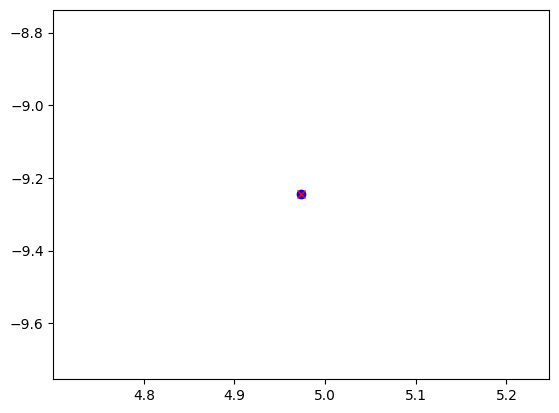

In [11]:
# Calculate the mean
mean_training_time = np.mean(training_time)
mean_val_loss = np.mean(val_loss)

# Calculate the standard deviation above and below the mean for training_time
training_time_above = training_time[training_time > mean_training_time] - mean_training_time
training_time_below = mean_training_time - training_time[training_time < mean_training_time]

std_training_time_above = np.std(np.concatenate((training_time_above, -training_time_above)))
std_training_time_below = np.std(np.concatenate((training_time_below, -training_time_below)))

# Calculate points above and below the mean for val_loss
val_loss_above = val_loss[val_loss > mean_val_loss] - mean_val_loss
val_loss_below = mean_val_loss - val_loss[val_loss < mean_val_loss]

std_val_loss_above = np.std(np.concatenate((val_loss_above, -val_loss_above)))
std_val_loss_below = np.std(np.concatenate((val_loss_below, -val_loss_below)))

# Plot scatter points
plt.scatter(training_time, val_loss, color='blue', label='Data Points')

# Add non-symmetrical error bars (standard deviations)
plt.errorbar(
    mean_training_time, mean_val_loss,
    xerr=[[std_training_time_below], [std_training_time_above]],  # Non-symmetrical x error
    yerr=[[std_val_loss_below], [std_val_loss_above]],  # Non-symmetrical y error
    fmt='x', color='red', ecolor='black', elinewidth=1.5, capsize=4, label='Mean ± STD'
)
plt.show()

# output_dir = os.path.join(script_dir, 'loss_data')
# output_path = os.path.join(output_dir, f"{filename}.txt")
# with open(output_path, 'w') as file:
#     file.write(f"{mean_training_time},{mean_val_loss},{std_training_time_above},{std_training_time_below},{std_val_loss_above},{std_val_loss_below}\n")


figures_per_row 3


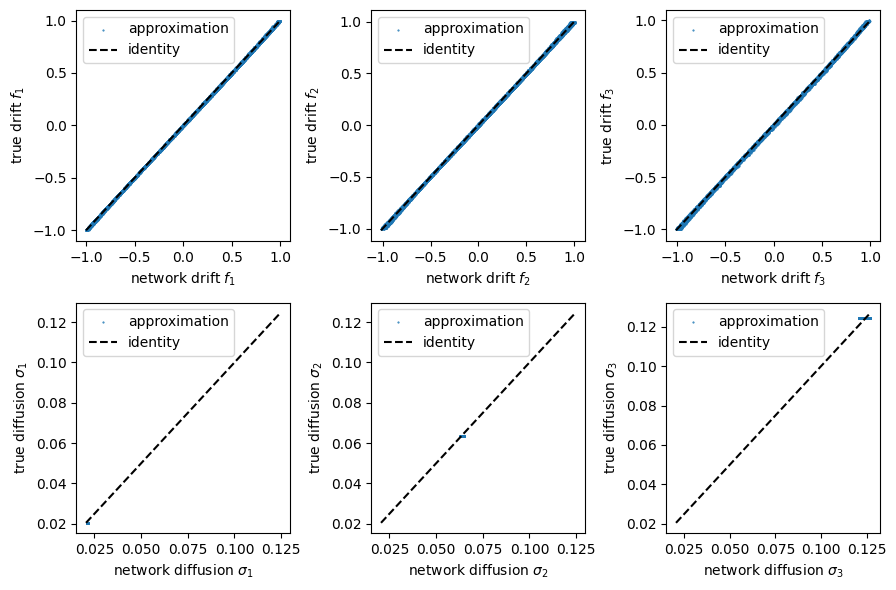

In [12]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(SAT.drift_diffusion, true_drift_diffusion,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

# output_dir = os.path.join(script_dir, 'trained_vs_true_plots')
# output_path = os.path.join(output_dir, f"{filename}")
# plt.savefig(output_path, dpi=300, bbox_inches='tight')

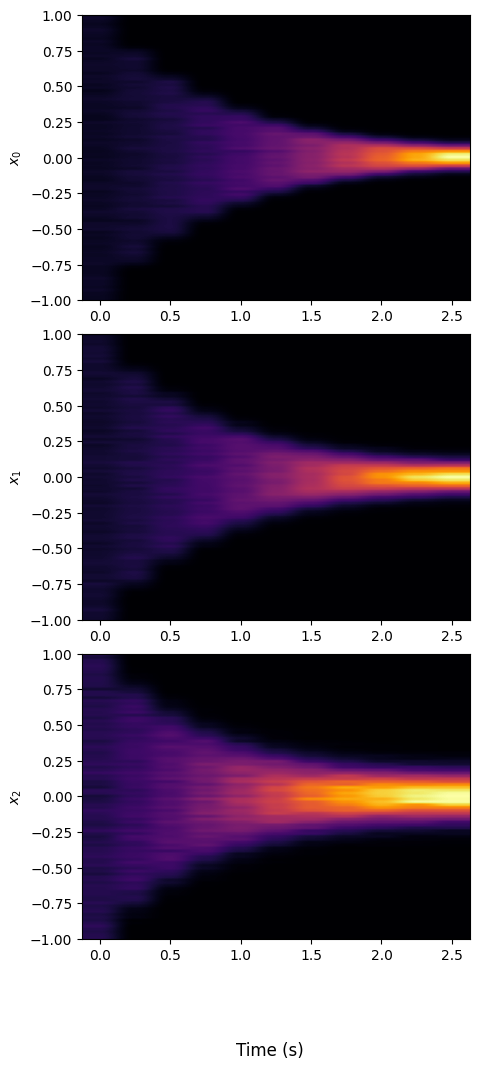

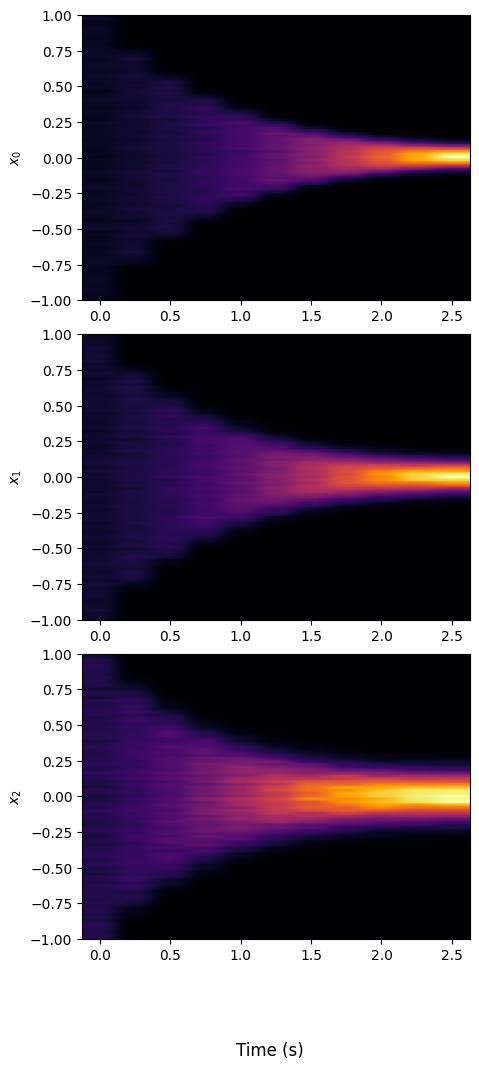

In [13]:
time = 10*step_size
true_paths = histogram_data(true_drift_diffusion, xlim, step_size, time, n_dimensions, random_seed)
ARFF_paths = histogram_data(SAT.drift_diffusion, xlim, step_size, time, n_dimensions, random_seed)

plot_histogram(true_paths, xlim, step_size)
plot_histogram(ARFF_paths, xlim, step_size)

# output_dir = os.path.join(script_dir, 'histogram_data')

# output_path_true = os.path.join(output_dir, f"{filename}_data.txt")
# with open(output_path_true, 'w') as file:
#     file.write(f"{step_size},{xlim}\n")

# output_path_true = os.path.join(output_dir, f"{filename}_true.npy")
# np.save(output_path_true, true_paths)

# output_path_ARFF = os.path.join(output_dir, f"{filename}_ARFF.npy")
# np.save(output_path_ARFF, ARFF_paths)